In [1]:
# VANILLA GAN ON TENSORFLOW
### This is my implementation of a generative adversarial network on tensorflow

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


## Architecture:
The GAN has a generator and a discriminator:
- The generator has two dense layers, and it outputs an image from a vector of uniform noise.
- The discriminator has two dense layers and it discriminates again images coming from the mnist database or those generated by the generator

In [3]:
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

class Gan(object):
    DEFAULTS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid,
    "regularization": tf.contrib.layers.l2_regularizer,
    "mu": 0,
    "sigma": 1.,
    "initializer": tf.contrib.layers.xavier_initializer()
    }
    RESTORE_KEY = "to_restore"


    def __init__(self, architecture=[], d_hyperparams={}, log_dir='./log'):
        self.architecture = architecture
        self.__dict__.update(Gan.DEFAULTS, **d_hyperparams)
        self.sesh = tf.Session()
        #TODO: decide if load a model or build a new one. For now, build it
        handles = self._build_graph()

      # In any case, make a collection of variables that are restore-able
        for handle in handles:
            tf.add_to_collection(Gan.RESTORE_KEY, handle)

        # initialize all globals of the session
        self.sesh.run(tf.global_variables_initializer())


        # Unpack the tuple of handles created by the builder
        (self.z, self.x_real, self.g_sample, self.D_loss, self.G_loss, 
             self.D_solver, self.G_solver, self.merged_summaries, self.global_step) = handles

        # Initialize the filewriter and write the graph (tensorboard)
        self.writer = tf.summary.FileWriter(log_dir, self.sesh.graph)

  
    def discriminator(self, x_in):
        # Discriminator gets a batch of images and returns a batch of probabilities.
        # The output has Identity activation_fn, so that the entropy in the cost
        # functions shall be computed with logits
        with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
            x = tf.contrib.layers.fully_connected(x_in, 128, activation_fn=self.nonlinearity,
                             weights_initializer=self.initializer)
            d_logit = tf.contrib.layers.fully_connected(x, 1, activation_fn=None,
                       weights_initializer=self.initializer)
            return x, d_logit
    
    def generator(self, z):
        # Generator net gets a batch of noise vectors and returns a batch of images
        with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
            x = tf.contrib.layers.fully_connected(z, self.architecture[0], activation_fn=self.nonlinearity, 
                              weights_initializer=self.initializer)
            g = tf.contrib.layers.fully_connected(x, 784, activation_fn=self.squashing,
                              weights_initializer=self.initializer)
            return g
      
    def generate(self, z):
        return self.sesh.run([self.g_sample], feed_dict={self.z: z})
    
    
    def _build_graph(self):
        z = tf.placeholder(tf.float32, shape=[None, self.architecture[0]], name='z')
        x_real = tf.placeholder(tf.float32, shape=[None, 784], name='x_real')

        # These nodes are the output of the generator/discrimiator for the batch
        # we will use them to compute the losses
        d_real, d_logit_real = self.discriminator(x_real)
        g_sample = self.generator(z)
        d_fake, d_logit_fake = self.discriminator(g_sample)

        # The losses:
        # Intuitively, we want:
        
        #the DISCRIMINATOR to be good at predicting:
        # a) That the real images are real (hence the cross entropy against 1)
        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, 
                                                                            labels=tf.ones_like(d_logit_real)),
                                    name='D_loss_real')
        # b) That the fake images are NOT real (hence the cross entropy agains 0)
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,
                                                                            labels=tf.zeros_like(d_logit_fake)),
                                    name='D_loss_fake')
        D_loss = tf.add(D_loss_real, D_loss_fake, name='D_loss')
        
        # the Generator to be good at generating images that the discriminator (mis)predicts are real
        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,
                                                                       labels=tf.ones_like(d_logit_fake)),
                               name='G_loss')

                
        # The optimizers (simpler but darker than compute; clip, apply)
        # There are two optimizers, each running on a group of variables while the others are constant.
        
        # Since they will all be run the same number of times for each minibatch, only one of them 
        # gets to advance the global_step
        
        global_step = tf.Variable(0, name='global_step', trainable=False)
        
        # Discriminator minimize grads. This one carries the global step
        # The solver only has to 'train' (modify) the TRAINABLE variables within the scope of
        # 'discriminator'
        D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')                
        D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_vars, 
                                                     global_step=global_step)

        # Generator minimize grads
        # The solver only has to 'train' (modify) the TRAINABLE variables within the scope of
        # 'generator'
        G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_vars)

        
        # append to summary
        with tf.name_scope('summaries'):
            with tf.name_scope('loss'):
                tf.summary.scalar('D_fake_loss', tf.reduce_sum(D_loss_fake, name='Dl_fake_scalar'))
                tf.summary.scalar('D_real_loss', tf.reduce_sum(D_loss_real, name='Dl_real_scalar'))
                tf.summary.scalar('D_loss', tf.reduce_sum(D_loss, name='Dl_scalar'))
                tf.summary.scalar('G_loss', tf.reduce_sum(G_loss, name='Gl_scalar'))
        summaries = tf.summary.merge_all()
        
        # Return nodes that the model needs to access
        return z, x_real, g_sample, D_loss, G_loss, D_solver, G_solver, summaries, global_step
    
    def train(self, X, max_iter=np.inf, max_epochs=np.inf, cross_validate=True, verbose=True):
        try:
            while True:
                x_real, _ = X.train.next_batch(self.batch_size)
                z = sample_z(self.batch_size, self.architecture[0])

                # run a step of the optimizer training for the discriminator,
                # with generator fixed
                D_solver, D_loss, i = self.sesh.run([self.D_solver, self.D_loss, self.global_step], 
                                            feed_dict = {self.x_real: x_real, self.z: z})

                # run a step of the optimizer training for the generator,
                # with discriminator fixed
                summary, G_solver, G_loss = self.sesh.run([self.merged_summaries, self.G_solver, self.G_loss], 
                                            feed_dict = {self.x_real: x_real, self.z: z})

                # output, logging and interruption arithmetics
                
                if i % 10 == 0:  # Record summaries and test-set accuracy
                    self.writer.add_summary(summary, i)
                if i%1000 ==0  and verbose:
                    print('Round {}, g_loss {}, d_loss {}'.format(i, G_loss, D_loss))
                    samples = self.generate(sample_z(16, self.architecture[0]))
                    fig = plot(samples[0])
                    plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
                    plt.show()

                if i>=max_iter or X.train.epochs_completed >= max_epochs:
                    print("final avg cost (@ step {} = epoch {})".format(
                        i, X.train.epochs_completed))
                    try:
                        self.writer.flush()
                        self.writer.close()
                    except(AttributeError):  # not logging
                        continue
                    break
                    
        except KeyboardInterrupt:
            print('Ended')

  


                    
z_dim = 100

gan = Gan(architecture=[z_dim])

Round 1000, g_loss 3.4864015579223633, d_loss 0.25865983963012695


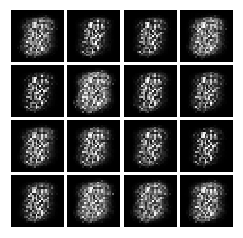

Round 2000, g_loss 5.0126824378967285, d_loss 0.2932140529155731


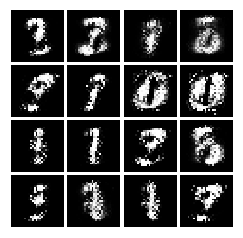

Round 3000, g_loss 4.316925048828125, d_loss 0.2669125497341156


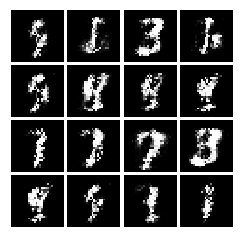

Round 4000, g_loss 4.470014572143555, d_loss 0.27554836869239807


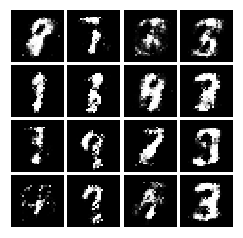

Round 5000, g_loss 3.9532241821289062, d_loss 0.3421437442302704


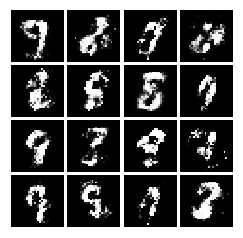

Round 6000, g_loss 3.603142261505127, d_loss 0.3532488942146301


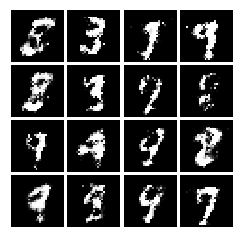

Round 7000, g_loss 3.0493478775024414, d_loss 0.5921730399131775


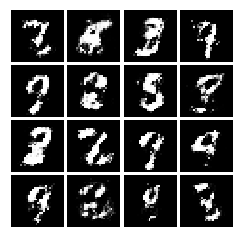

Round 8000, g_loss 3.2813780307769775, d_loss 0.39230862259864807


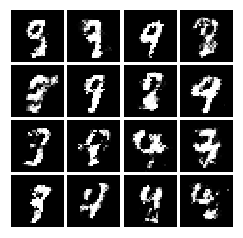

Round 9000, g_loss 3.4047179222106934, d_loss 0.34615230560302734


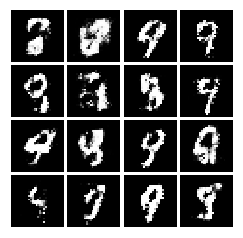

Round 10000, g_loss 3.0599536895751953, d_loss 0.42260822653770447


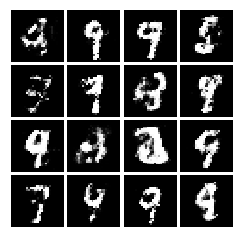

Round 11000, g_loss 3.6685068607330322, d_loss 0.319926381111145


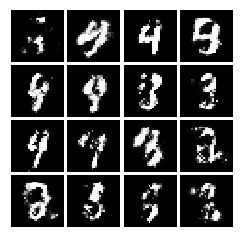

Round 12000, g_loss 3.191977024078369, d_loss 0.31151968240737915


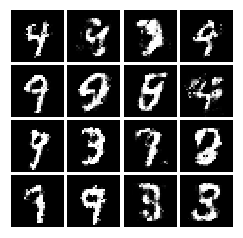

Round 13000, g_loss 3.0460944175720215, d_loss 0.39152997732162476


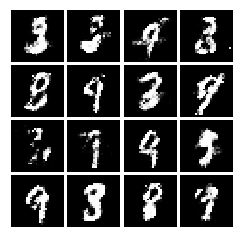

Round 14000, g_loss 3.2319719791412354, d_loss 0.4318041205406189


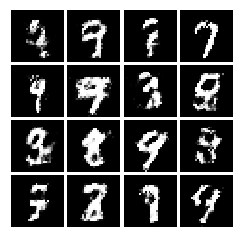

Round 15000, g_loss 2.7570700645446777, d_loss 0.41118377447128296


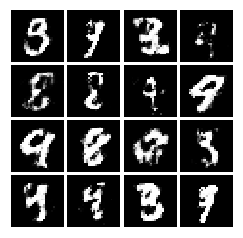

Round 16000, g_loss 3.18040132522583, d_loss 0.3468172550201416


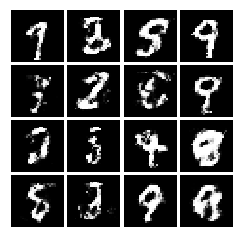

Round 17000, g_loss 2.94608998298645, d_loss 0.46132999658584595


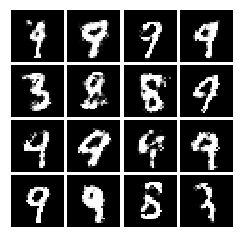

Round 18000, g_loss 2.8557052612304688, d_loss 0.3486012816429138


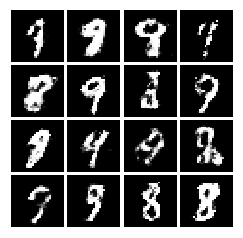

Round 19000, g_loss 2.6337010860443115, d_loss 0.48100546002388


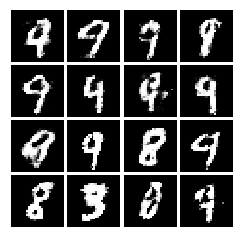

Round 20000, g_loss 3.1480560302734375, d_loss 0.41019394993782043


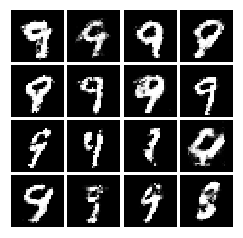

Round 21000, g_loss 2.734175205230713, d_loss 0.49215731024742126


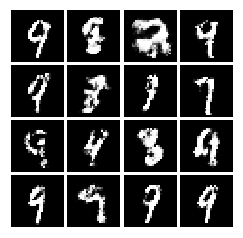

Round 22000, g_loss 3.0673091411590576, d_loss 0.5171213746070862


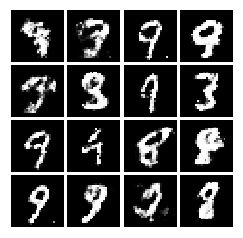

Round 23000, g_loss 2.9052534103393555, d_loss 0.4819531738758087


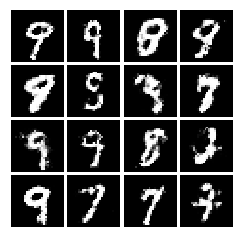

Round 24000, g_loss 2.901031732559204, d_loss 0.3690125346183777


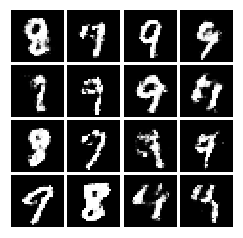

Round 25000, g_loss 3.093686103820801, d_loss 0.45898640155792236


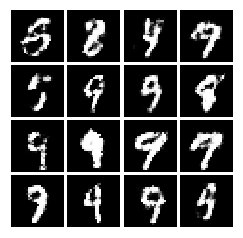

Round 26000, g_loss 3.1170012950897217, d_loss 0.39344021677970886


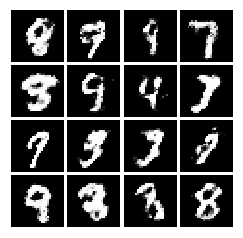

Round 27000, g_loss 3.002911329269409, d_loss 0.4093594551086426


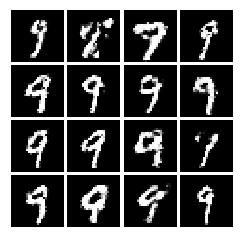

Round 28000, g_loss 3.139089345932007, d_loss 0.3582826852798462


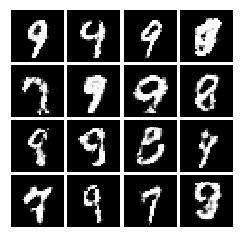

Round 29000, g_loss 3.1818528175354004, d_loss 0.37720924615859985


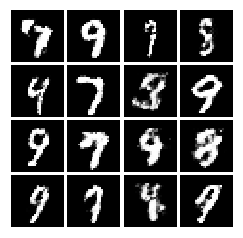

Round 30000, g_loss 3.533811330795288, d_loss 0.3653569519519806


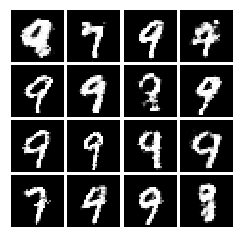

Round 31000, g_loss 2.9542195796966553, d_loss 0.37580907344818115


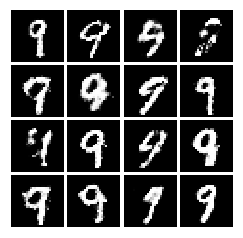

Round 32000, g_loss 2.880033254623413, d_loss 0.4119742512702942


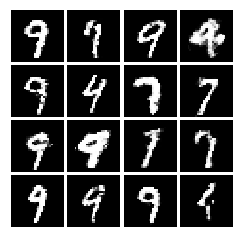

Round 33000, g_loss 2.908263683319092, d_loss 0.5827388763427734


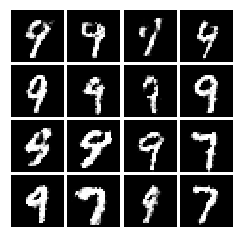

Round 34000, g_loss 2.840426445007324, d_loss 0.4268960952758789


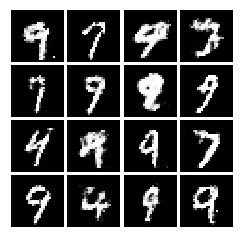

Round 35000, g_loss 3.77323579788208, d_loss 0.4132375121116638


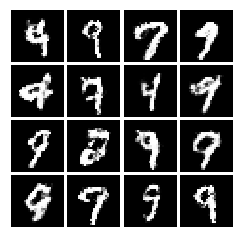

Round 36000, g_loss 3.1920394897460938, d_loss 0.36794596910476685


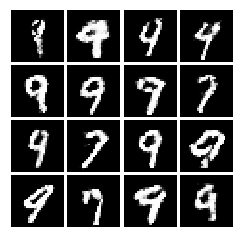

Round 37000, g_loss 2.926417350769043, d_loss 0.34877556562423706


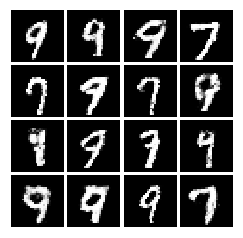

Round 38000, g_loss 3.034658908843994, d_loss 0.5231482982635498


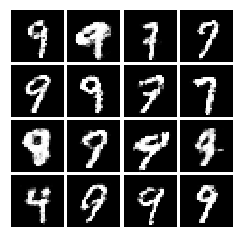

Round 39000, g_loss 3.4055733680725098, d_loss 0.4522666931152344


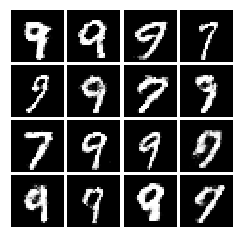

Round 40000, g_loss 3.017329692840576, d_loss 0.28212833404541016


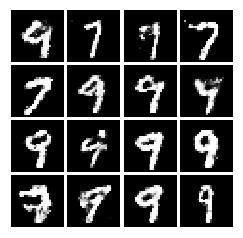

Round 41000, g_loss 3.3229122161865234, d_loss 0.3578439950942993


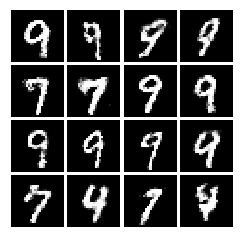

Round 42000, g_loss 3.029048442840576, d_loss 0.34799739718437195


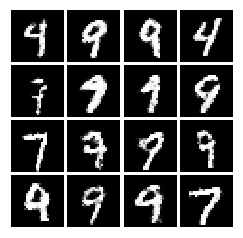

Round 43000, g_loss 2.4596080780029297, d_loss 0.3598058223724365


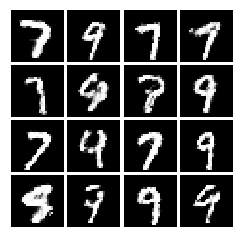

Round 44000, g_loss 3.218096971511841, d_loss 0.38628488779067993


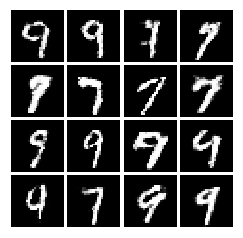

Round 45000, g_loss 3.064365863800049, d_loss 0.3922792673110962


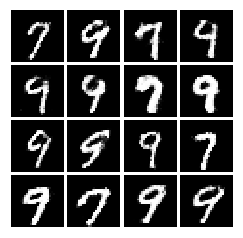

Round 46000, g_loss 3.3324615955352783, d_loss 0.2379741370677948


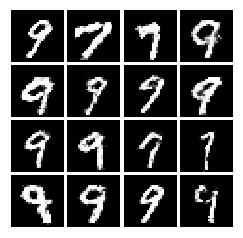

Round 47000, g_loss 2.9034423828125, d_loss 0.47804105281829834


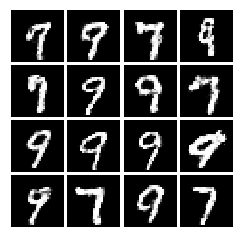

Round 48000, g_loss 2.767704486846924, d_loss 0.32728248834609985


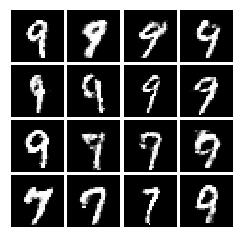

Round 49000, g_loss 2.8991270065307617, d_loss 0.2661989629268646


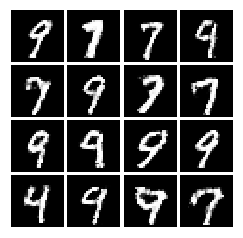

Round 50000, g_loss 2.6785707473754883, d_loss 0.35008496046066284


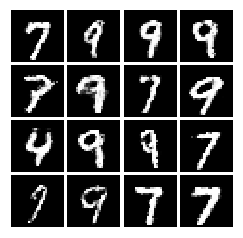

Round 51000, g_loss 3.43660044670105, d_loss 0.3387085795402527


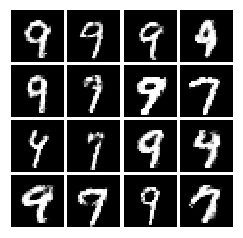

Round 52000, g_loss 2.876244306564331, d_loss 0.44333571195602417


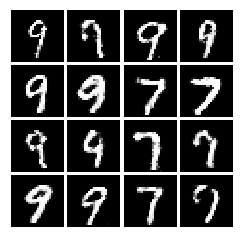

Round 53000, g_loss 2.6716465950012207, d_loss 0.4225161075592041


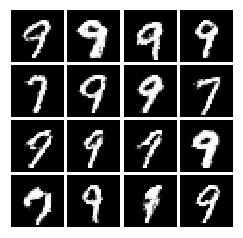

Round 54000, g_loss 2.3824474811553955, d_loss 0.4262438118457794


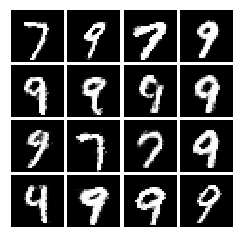

Round 55000, g_loss 2.971134901046753, d_loss 0.3138600289821625


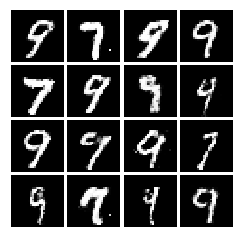

Round 56000, g_loss 2.974029541015625, d_loss 0.3117264211177826


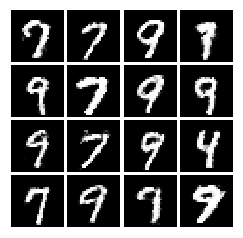

Round 57000, g_loss 2.7935616970062256, d_loss 0.3174094557762146


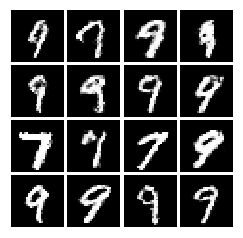

Round 58000, g_loss 2.802025556564331, d_loss 0.5174744129180908


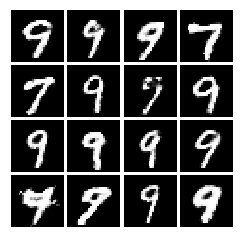

Round 59000, g_loss 2.7544236183166504, d_loss 0.3321778178215027


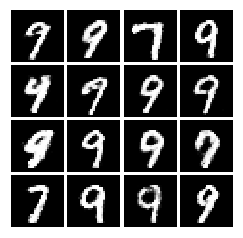

Round 60000, g_loss 2.8094019889831543, d_loss 0.3109477162361145


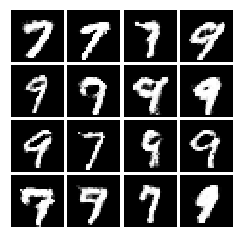

Round 61000, g_loss 3.1117587089538574, d_loss 0.4276776909828186


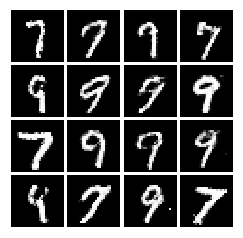

Round 62000, g_loss 2.6144773960113525, d_loss 0.4107322096824646


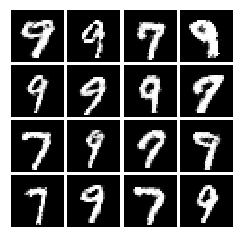

Round 63000, g_loss 2.323380947113037, d_loss 0.3661315441131592


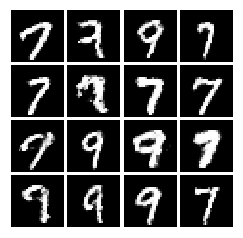

Round 64000, g_loss 2.8135600090026855, d_loss 0.3155800402164459


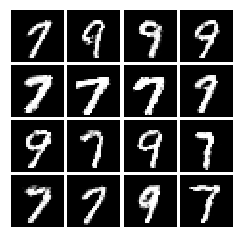

Round 65000, g_loss 3.1380183696746826, d_loss 0.25618934631347656


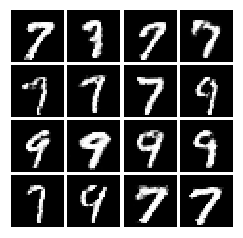

Round 66000, g_loss 2.7693264484405518, d_loss 0.32363420724868774


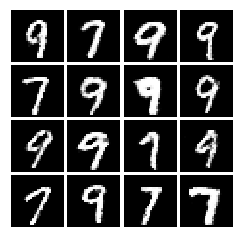

Round 67000, g_loss 2.5837368965148926, d_loss 0.31151601672172546


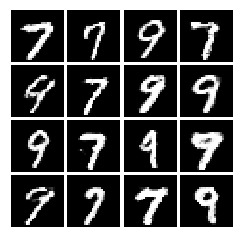

Round 68000, g_loss 2.633604049682617, d_loss 0.3739645183086395


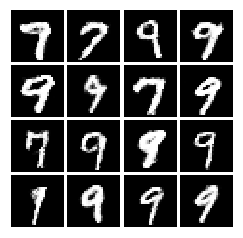

Round 69000, g_loss 2.8687047958374023, d_loss 0.2742980122566223


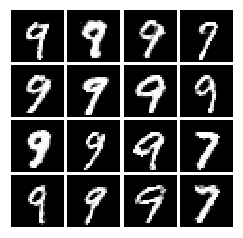

Round 70000, g_loss 3.1383841037750244, d_loss 0.1944875717163086


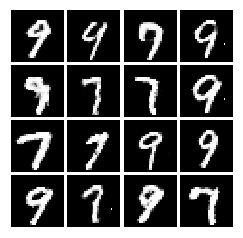

Round 71000, g_loss 2.8566701412200928, d_loss 0.4516456723213196


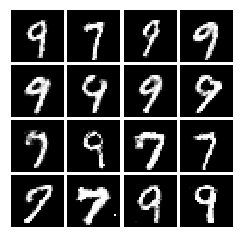

Round 72000, g_loss 3.0764808654785156, d_loss 0.3506509065628052


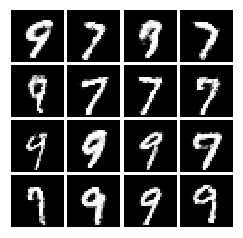

Round 73000, g_loss 2.7505874633789062, d_loss 0.35870257019996643


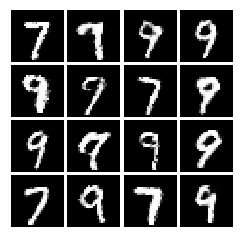

Round 74000, g_loss 2.8193840980529785, d_loss 0.32123517990112305


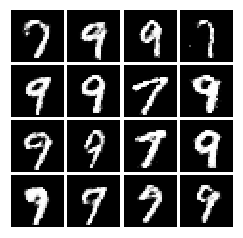

Round 75000, g_loss 2.9220821857452393, d_loss 0.2923548221588135


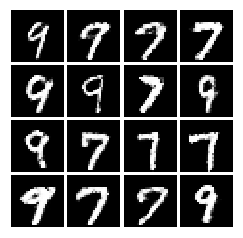

Round 76000, g_loss 2.978182792663574, d_loss 0.3844591975212097


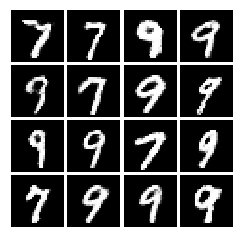

Round 77000, g_loss 3.110964775085449, d_loss 0.3484139144420624


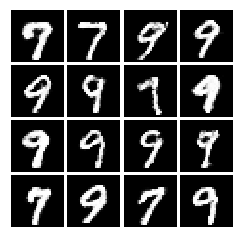

Round 78000, g_loss 3.454641103744507, d_loss 0.27655497193336487


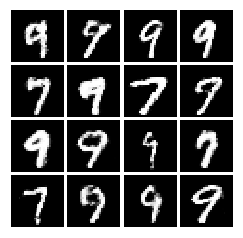

Round 79000, g_loss 2.801774501800537, d_loss 0.3198309540748596


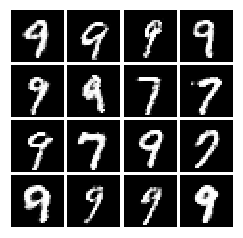

Round 80000, g_loss 2.7432336807250977, d_loss 0.3581241965293884


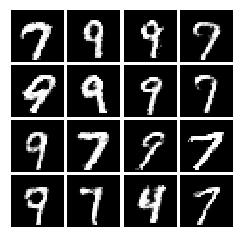

Round 81000, g_loss 2.950928211212158, d_loss 0.28189608454704285


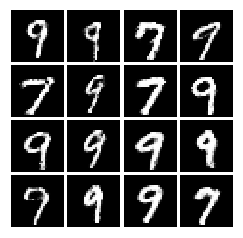

Round 82000, g_loss 2.9532949924468994, d_loss 0.33932971954345703


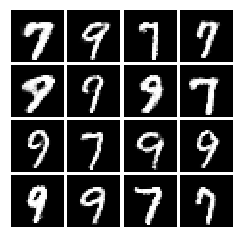

Round 83000, g_loss 2.7904069423675537, d_loss 0.33536410331726074


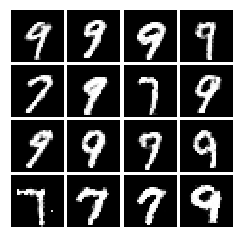

Round 84000, g_loss 3.104642391204834, d_loss 0.27891790866851807


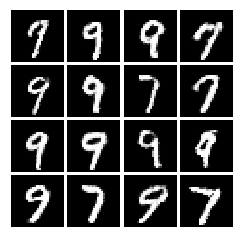

Round 85000, g_loss 2.6761765480041504, d_loss 0.3332659602165222


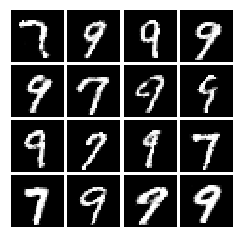

Round 86000, g_loss 2.9558591842651367, d_loss 0.31034529209136963


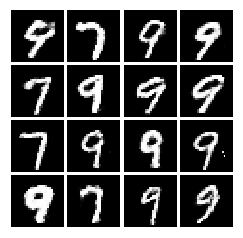

Round 87000, g_loss 3.017524242401123, d_loss 0.3431743383407593


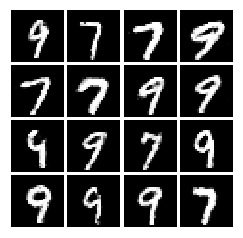

Round 88000, g_loss 3.1541502475738525, d_loss 0.22845111787319183


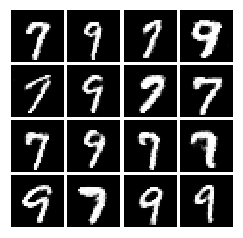

Round 89000, g_loss 3.2948191165924072, d_loss 0.22264911234378815


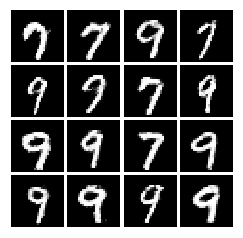

Round 90000, g_loss 2.9788641929626465, d_loss 0.24845296144485474


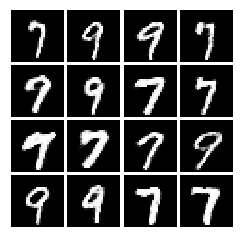

Round 91000, g_loss 3.0528032779693604, d_loss 0.30744078755378723


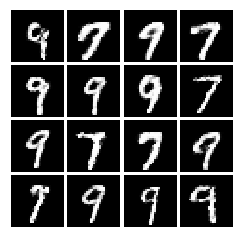

Round 92000, g_loss 3.1742115020751953, d_loss 0.3854348063468933


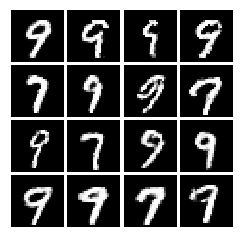

Round 93000, g_loss 3.128988742828369, d_loss 0.2124200165271759


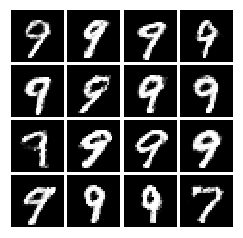

Round 94000, g_loss 3.171370506286621, d_loss 0.2973977327346802


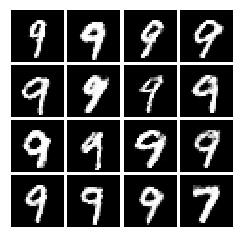

Round 95000, g_loss 2.691253662109375, d_loss 0.2965141236782074


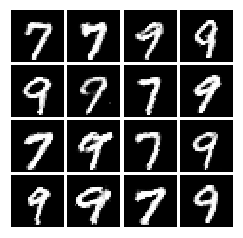

Round 96000, g_loss 2.788486957550049, d_loss 0.24495774507522583


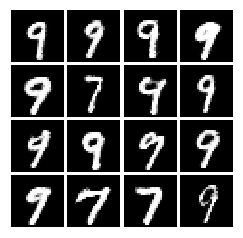

Round 97000, g_loss 3.172481060028076, d_loss 0.2538619637489319


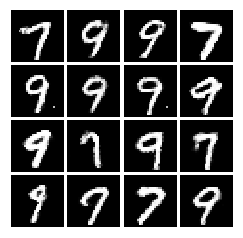

Round 98000, g_loss 3.339571714401245, d_loss 0.2673698663711548


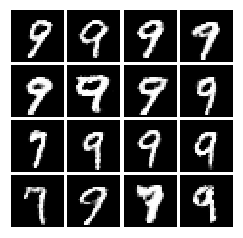

Round 99000, g_loss 2.955941915512085, d_loss 0.31092631816864014


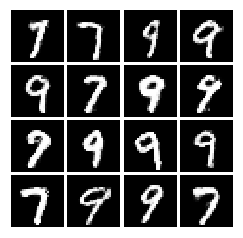

Round 100000, g_loss 2.800588607788086, d_loss 0.31034696102142334


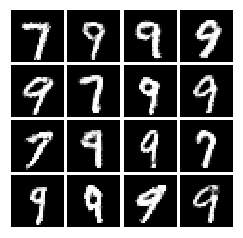

Round 101000, g_loss 3.0227339267730713, d_loss 0.22460952401161194


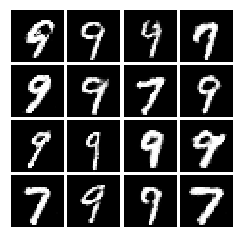

Round 102000, g_loss 3.1663732528686523, d_loss 0.2652706503868103


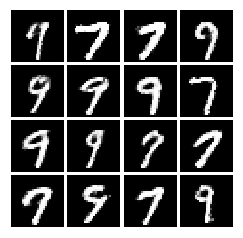

Round 103000, g_loss 2.9942164421081543, d_loss 0.26415854692459106


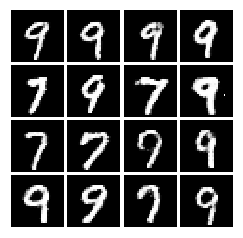

Round 104000, g_loss 3.0046262741088867, d_loss 0.28313273191452026


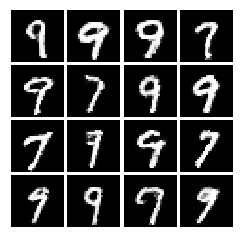

Round 105000, g_loss 3.142180919647217, d_loss 0.2413340061903


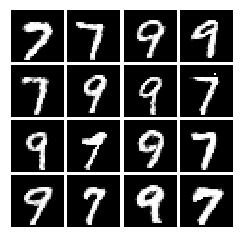

Round 106000, g_loss 3.490286350250244, d_loss 0.3377590775489807


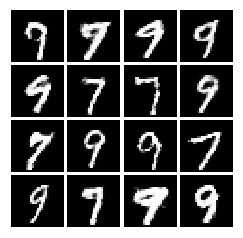

Round 107000, g_loss 2.7836837768554688, d_loss 0.2670193910598755


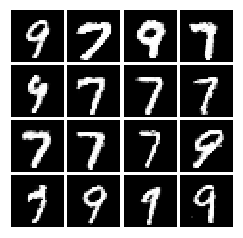

Round 108000, g_loss 3.272484302520752, d_loss 0.27352002263069153


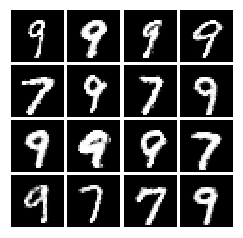

Round 109000, g_loss 3.0011353492736816, d_loss 0.2813286781311035


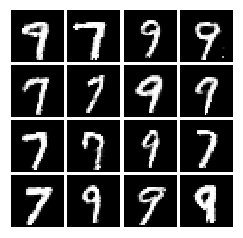

Round 110000, g_loss 3.3348536491394043, d_loss 0.2980740964412689


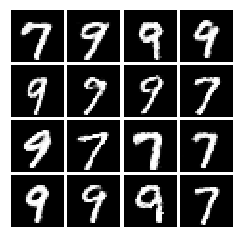

Round 111000, g_loss 2.886296272277832, d_loss 0.39315229654312134


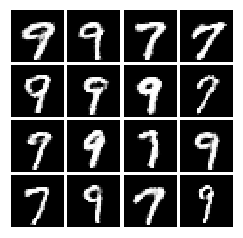

Round 112000, g_loss 2.9661808013916016, d_loss 0.3348095715045929


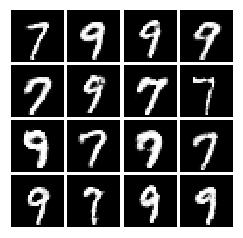

Round 113000, g_loss 2.965287208557129, d_loss 0.37149569392204285


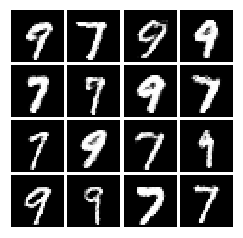

Round 114000, g_loss 3.230581283569336, d_loss 0.2668119966983795


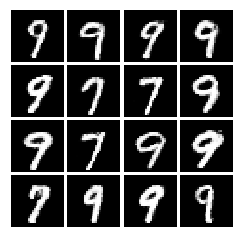

Round 115000, g_loss 2.6862854957580566, d_loss 0.34670090675354004


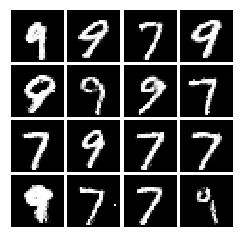

Round 116000, g_loss 3.227778434753418, d_loss 0.3005163371562958


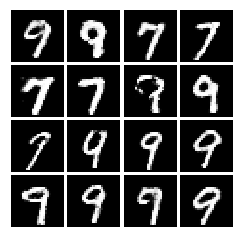

Round 117000, g_loss 3.511655330657959, d_loss 0.24223032593727112


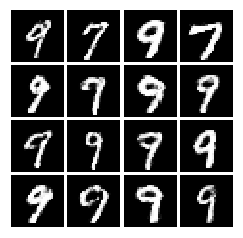

Round 118000, g_loss 3.0779082775115967, d_loss 0.2979215383529663


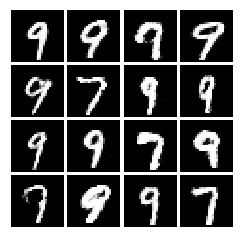

Round 119000, g_loss 3.327061176300049, d_loss 0.21722576022148132


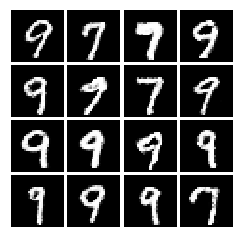

Round 120000, g_loss 3.3327813148498535, d_loss 0.3203089237213135


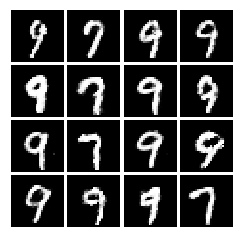

Round 121000, g_loss 3.370187520980835, d_loss 0.25495684146881104


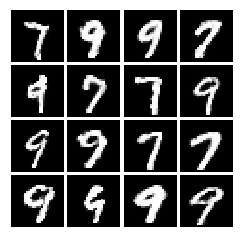

Round 122000, g_loss 2.8454227447509766, d_loss 0.27424535155296326


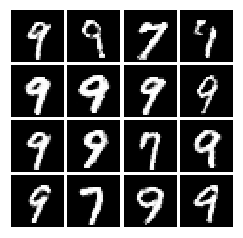

Round 123000, g_loss 2.986841917037964, d_loss 0.40190479159355164


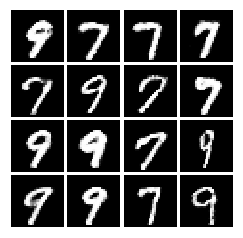

Round 124000, g_loss 3.3206422328948975, d_loss 0.25172409415245056


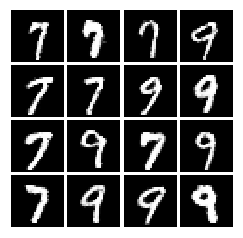

Round 125000, g_loss 3.315244674682617, d_loss 0.30896979570388794


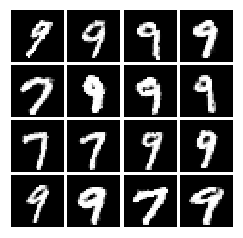

Round 126000, g_loss 3.103104591369629, d_loss 0.4123440086841583


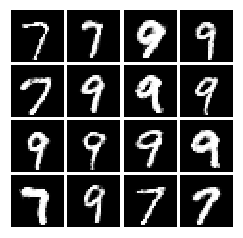

Round 127000, g_loss 3.1766626834869385, d_loss 0.19824811816215515


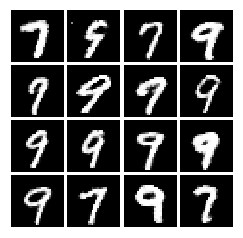

Round 128000, g_loss 3.193070888519287, d_loss 0.3326573967933655


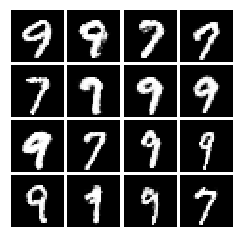

Round 129000, g_loss 3.2085537910461426, d_loss 0.19425195455551147


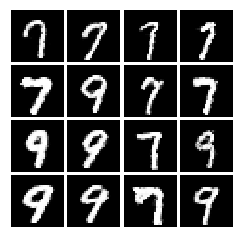

Round 130000, g_loss 2.910421848297119, d_loss 0.23383523523807526


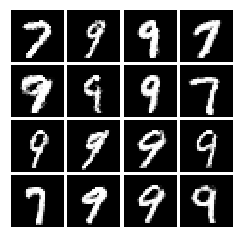

Round 131000, g_loss 3.3321421146392822, d_loss 0.2656997740268707


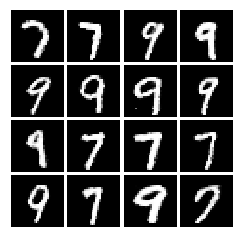

Round 132000, g_loss 2.8680813312530518, d_loss 0.3636934161186218


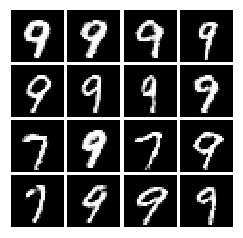

Round 133000, g_loss 3.3355302810668945, d_loss 0.3501995801925659


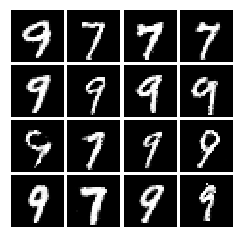

Round 134000, g_loss 3.4615774154663086, d_loss 0.33238649368286133


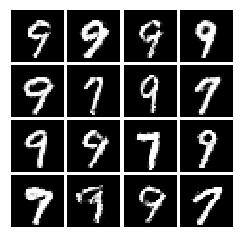

Round 135000, g_loss 3.368198871612549, d_loss 0.26007211208343506


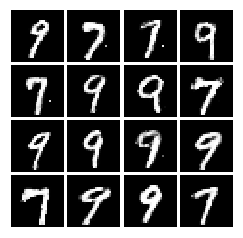

Round 136000, g_loss 2.990222930908203, d_loss 0.2221577763557434


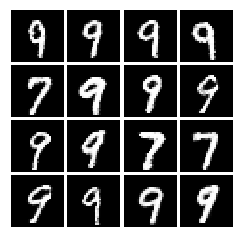

Round 137000, g_loss 3.415060520172119, d_loss 0.14641931653022766


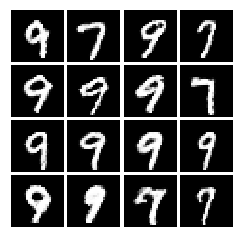

Round 138000, g_loss 3.266047954559326, d_loss 0.36546188592910767


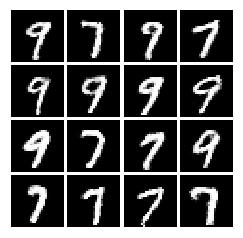

Round 139000, g_loss 3.1042370796203613, d_loss 0.3165722191333771


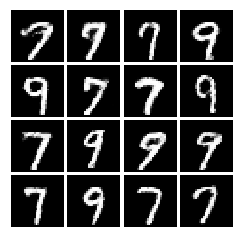

Round 140000, g_loss 2.9312918186187744, d_loss 0.39171916246414185


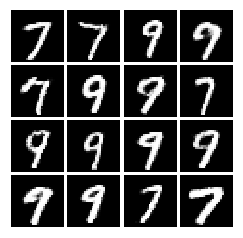

Round 141000, g_loss 3.2607531547546387, d_loss 0.22806549072265625


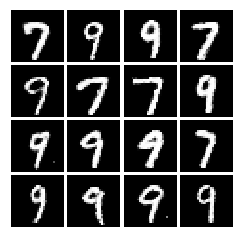

Round 142000, g_loss 3.5123579502105713, d_loss 0.21297430992126465


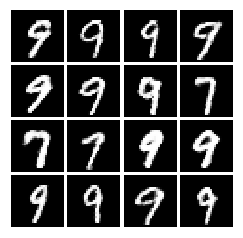

Round 143000, g_loss 2.998218536376953, d_loss 0.2233215868473053


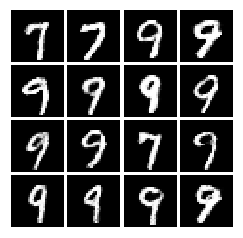

Round 144000, g_loss 2.8920350074768066, d_loss 0.3868666887283325


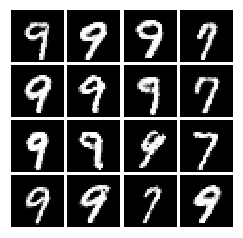

Round 145000, g_loss 3.416788339614868, d_loss 0.2816685140132904


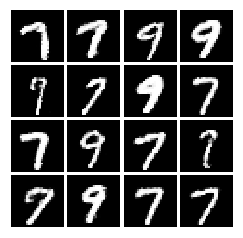

Round 146000, g_loss 2.98862361907959, d_loss 0.2656039297580719


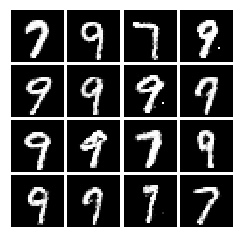

Round 147000, g_loss 3.323198080062866, d_loss 0.2166936993598938


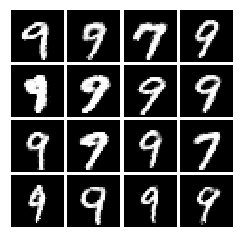

Round 148000, g_loss 3.055628776550293, d_loss 0.2696616053581238


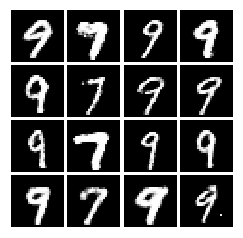

Round 149000, g_loss 3.378748655319214, d_loss 0.3658094108104706


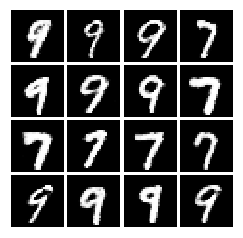

Round 150000, g_loss 3.38277006149292, d_loss 0.3134196400642395


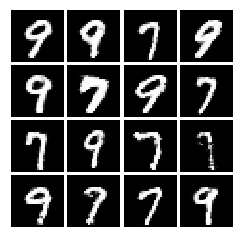

Round 151000, g_loss 3.6536977291107178, d_loss 0.3016164302825928


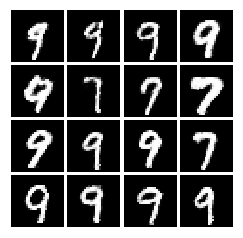

Round 152000, g_loss 3.198037624359131, d_loss 0.2130732536315918


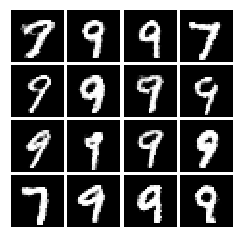

Round 153000, g_loss 2.9515328407287598, d_loss 0.3031153082847595


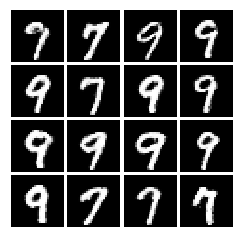

Round 154000, g_loss 3.4667623043060303, d_loss 0.18985599279403687


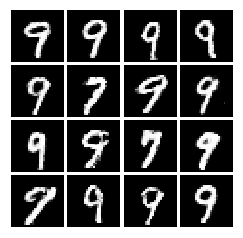

Round 155000, g_loss 3.3002123832702637, d_loss 0.27576711773872375


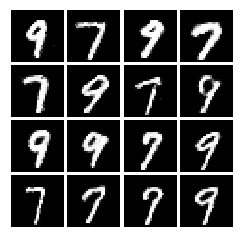

Round 156000, g_loss 3.121819496154785, d_loss 0.28804540634155273


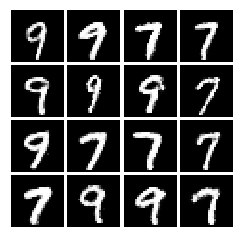

Round 157000, g_loss 3.3232784271240234, d_loss 0.27891188859939575


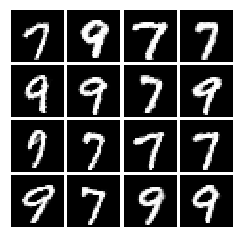

Round 158000, g_loss 3.192986011505127, d_loss 0.2479308843612671


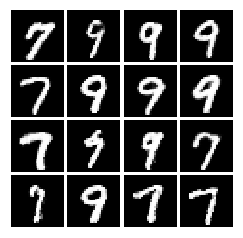

Round 159000, g_loss 3.299593687057495, d_loss 0.33963727951049805


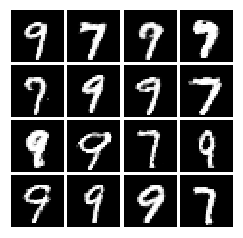

Round 160000, g_loss 3.4067232608795166, d_loss 0.23565778136253357


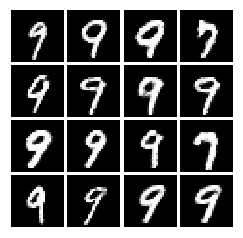

Round 161000, g_loss 3.3719611167907715, d_loss 0.20460692048072815


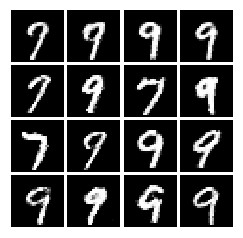

Round 162000, g_loss 3.5802817344665527, d_loss 0.15351003408432007


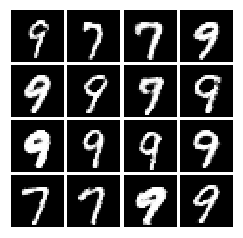

Round 163000, g_loss 3.539123058319092, d_loss 0.16838476061820984


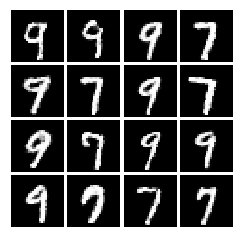

Round 164000, g_loss 3.8025975227355957, d_loss 0.32097965478897095


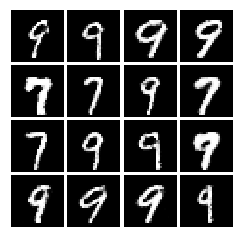

Round 165000, g_loss 3.2157604694366455, d_loss 0.2455085813999176


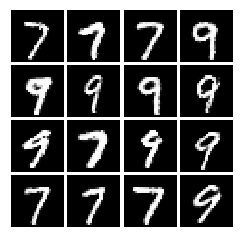

Round 166000, g_loss 3.3548216819763184, d_loss 0.240513414144516


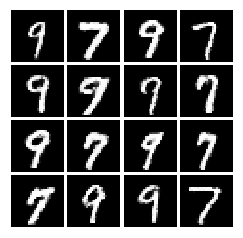

Round 167000, g_loss 2.9192957878112793, d_loss 0.25327372550964355


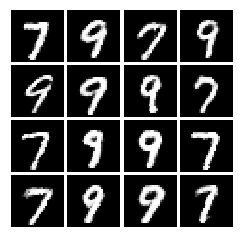

Round 168000, g_loss 3.4971752166748047, d_loss 0.21058496832847595


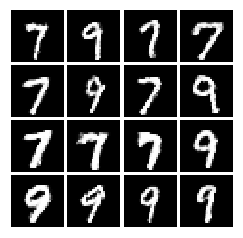

Round 169000, g_loss 3.515925168991089, d_loss 0.3262985348701477


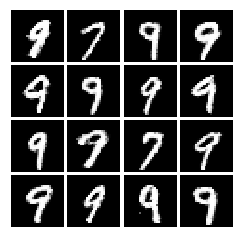

Round 170000, g_loss 3.238563060760498, d_loss 0.20629307627677917


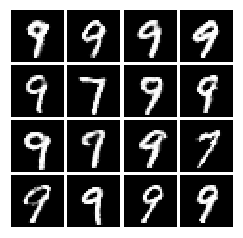

Round 171000, g_loss 3.5039587020874023, d_loss 0.32438039779663086


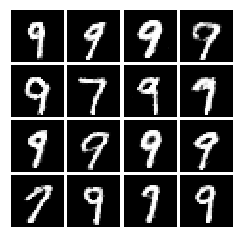

Round 172000, g_loss 2.909977674484253, d_loss 0.3386680483818054


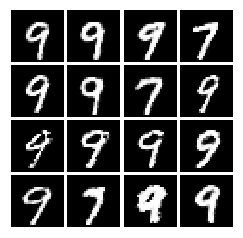

Round 173000, g_loss 3.54083514213562, d_loss 0.2870278060436249


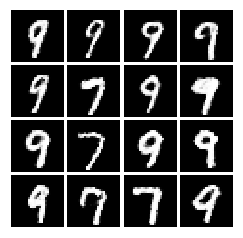

Round 174000, g_loss 3.135270833969116, d_loss 0.29931116104125977


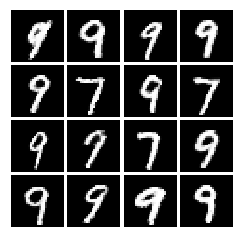

Round 175000, g_loss 3.4930334091186523, d_loss 0.33449405431747437


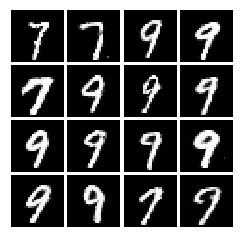

Round 176000, g_loss 3.3714053630828857, d_loss 0.25603681802749634


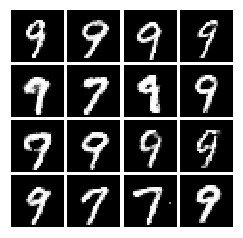

Round 177000, g_loss 3.4567692279815674, d_loss 0.2838987410068512


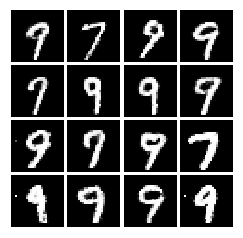

Round 178000, g_loss 3.6664962768554688, d_loss 0.21042299270629883


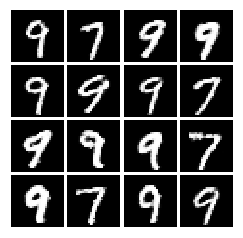

Round 179000, g_loss 3.6463966369628906, d_loss 0.22431200742721558


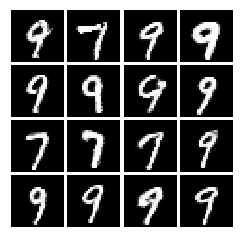

Round 180000, g_loss 3.4057912826538086, d_loss 0.19610147178173065


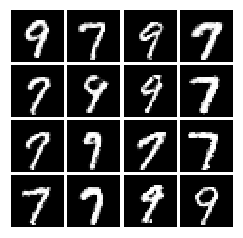

Round 181000, g_loss 3.6302850246429443, d_loss 0.17264637351036072


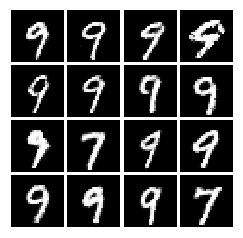

Round 182000, g_loss 3.2638731002807617, d_loss 0.24304229021072388


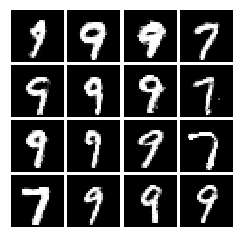

Round 183000, g_loss 3.4983129501342773, d_loss 0.24942444264888763


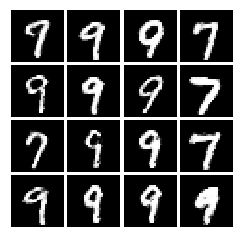

Round 184000, g_loss 3.2731411457061768, d_loss 0.3347426652908325


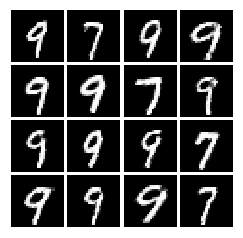

Round 185000, g_loss 3.6808395385742188, d_loss 0.16919802129268646


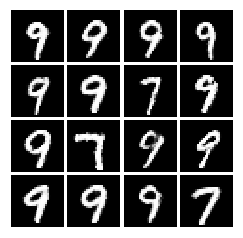

Round 186000, g_loss 3.2825028896331787, d_loss 0.2987821102142334


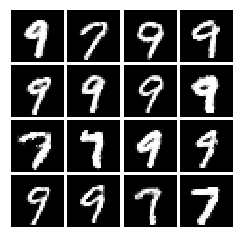

Round 187000, g_loss 3.5381555557250977, d_loss 0.30302104353904724


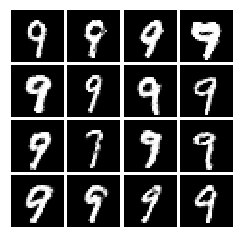

Round 188000, g_loss 3.1772334575653076, d_loss 0.225192129611969


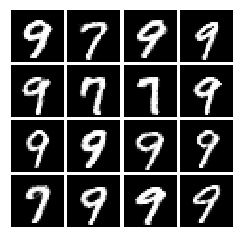

Round 189000, g_loss 3.6839804649353027, d_loss 0.34588998556137085


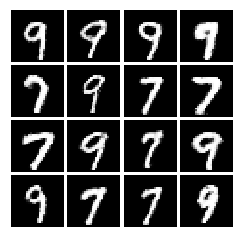

Round 190000, g_loss 3.7476415634155273, d_loss 0.20480258762836456


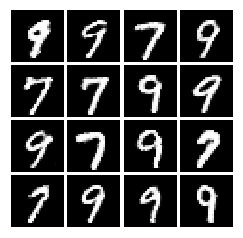

Round 191000, g_loss 3.2740836143493652, d_loss 0.23405325412750244


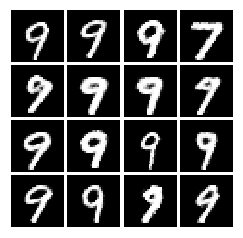

Round 192000, g_loss 3.7353057861328125, d_loss 0.20257854461669922


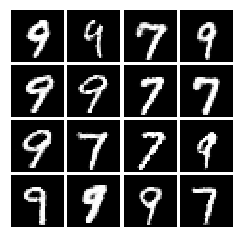

Round 193000, g_loss 3.5679116249084473, d_loss 0.3719223141670227


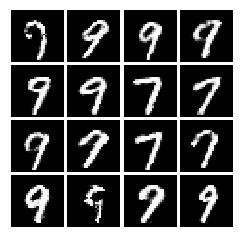

Round 194000, g_loss 3.3434643745422363, d_loss 0.34421026706695557


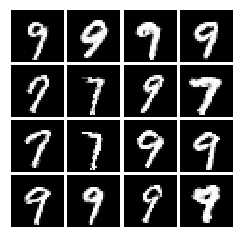

Round 195000, g_loss 3.216326951980591, d_loss 0.2927934527397156


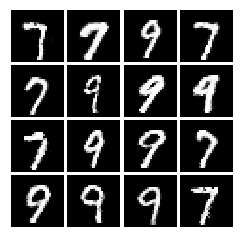

Round 196000, g_loss 3.4789035320281982, d_loss 0.22296074032783508


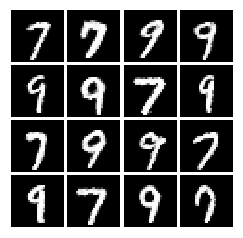

Round 197000, g_loss 3.3639328479766846, d_loss 0.28993359208106995


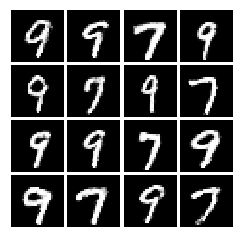

Round 198000, g_loss 3.839550018310547, d_loss 0.30886566638946533


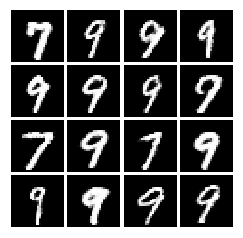

Round 199000, g_loss 4.267801284790039, d_loss 0.13249406218528748


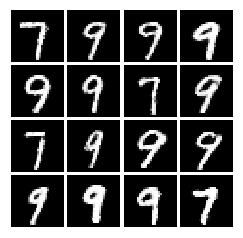

Round 200000, g_loss 3.506453514099121, d_loss 0.254219651222229


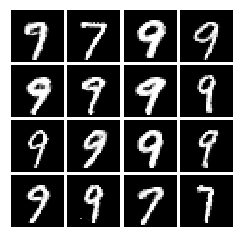

Round 201000, g_loss 3.4139037132263184, d_loss 0.19221115112304688


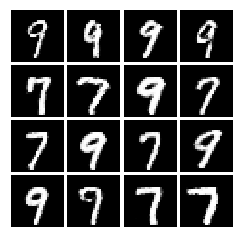

Round 202000, g_loss 3.5538058280944824, d_loss 0.13340559601783752


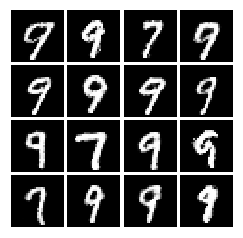

Round 203000, g_loss 3.5815629959106445, d_loss 0.15934821963310242


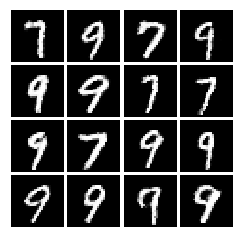

Round 204000, g_loss 3.8217501640319824, d_loss 0.2944270372390747


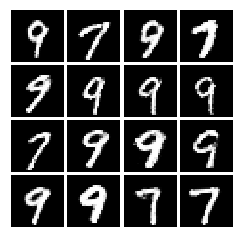

Round 205000, g_loss 3.654521942138672, d_loss 0.20796599984169006


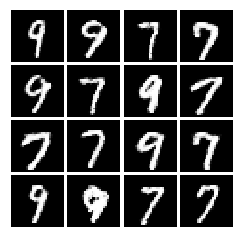

Round 206000, g_loss 3.6491951942443848, d_loss 0.21773198246955872


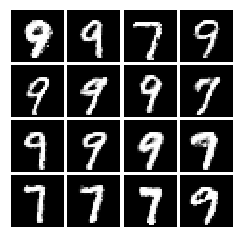

Round 207000, g_loss 3.4863364696502686, d_loss 0.23432087898254395


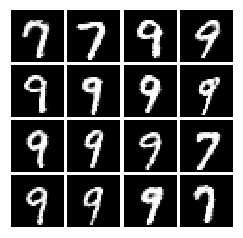

Round 208000, g_loss 3.4288885593414307, d_loss 0.23125536739826202


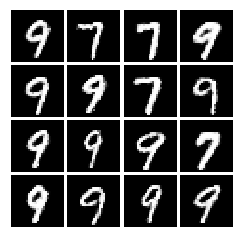

Round 209000, g_loss 3.4434452056884766, d_loss 0.2952110469341278


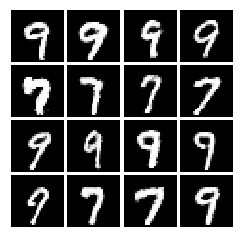

Round 210000, g_loss 3.696213722229004, d_loss 0.4196511507034302


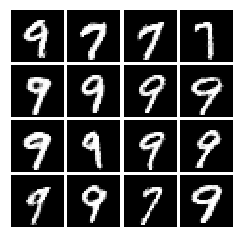

Round 211000, g_loss 3.4326610565185547, d_loss 0.22922563552856445


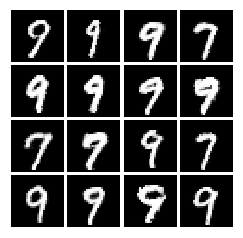

Round 212000, g_loss 3.919210910797119, d_loss 0.23198112845420837


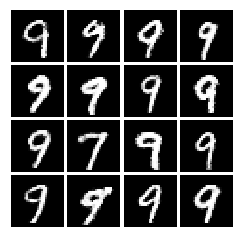

Round 213000, g_loss 4.160019397735596, d_loss 0.2608965039253235


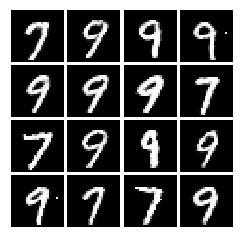

Round 214000, g_loss 3.466367721557617, d_loss 0.3521917164325714


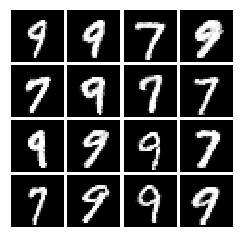

Round 215000, g_loss 3.601067304611206, d_loss 0.2587471604347229


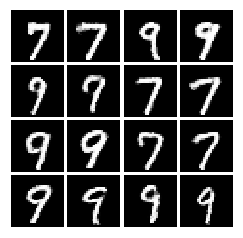

Round 216000, g_loss 3.61965012550354, d_loss 0.2913547456264496


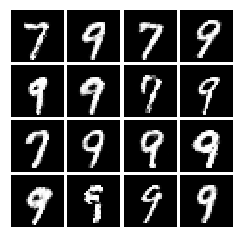

Round 217000, g_loss 3.4710261821746826, d_loss 0.32428792119026184


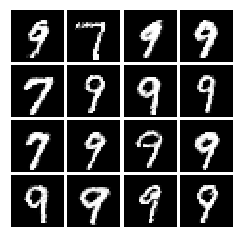

Round 218000, g_loss 3.436610698699951, d_loss 0.23766225576400757


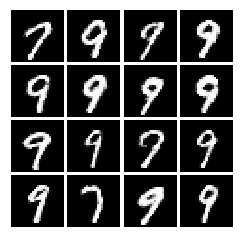

Round 219000, g_loss 3.1360392570495605, d_loss 0.17430123686790466


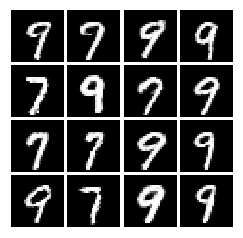

Round 220000, g_loss 3.9949872493743896, d_loss 0.36394166946411133


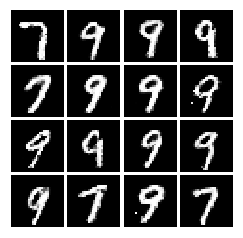

Round 221000, g_loss 3.5099916458129883, d_loss 0.1465740203857422


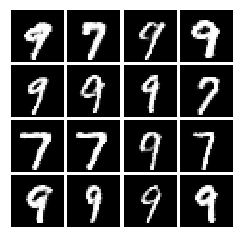

Round 222000, g_loss 3.7395715713500977, d_loss 0.10686824470758438


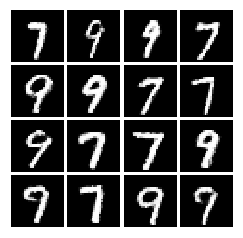

Round 223000, g_loss 3.5510878562927246, d_loss 0.2095317840576172


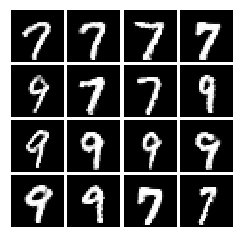

Round 224000, g_loss 4.013446807861328, d_loss 0.23338210582733154


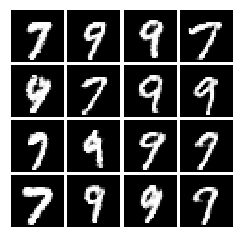

Round 225000, g_loss 3.4454827308654785, d_loss 0.2024865448474884


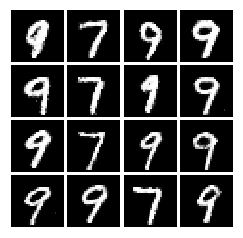

Round 226000, g_loss 3.5855751037597656, d_loss 0.24472880363464355


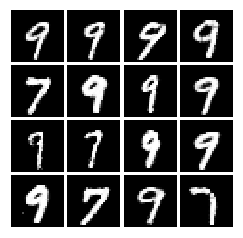

Round 227000, g_loss 3.6081111431121826, d_loss 0.1919049471616745


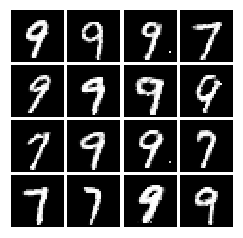

Round 228000, g_loss 3.838160276412964, d_loss 0.2177480012178421


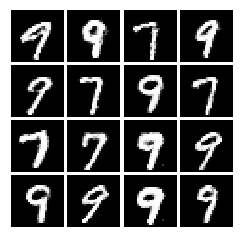

Round 229000, g_loss 3.7419867515563965, d_loss 0.08129540085792542


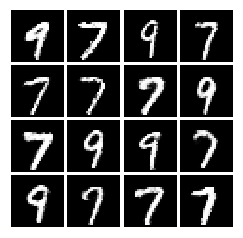

Round 230000, g_loss 4.21737003326416, d_loss 0.23490053415298462


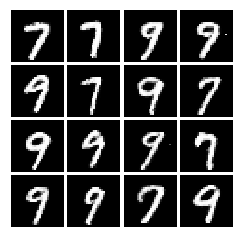

Round 231000, g_loss 3.583418607711792, d_loss 0.25307005643844604


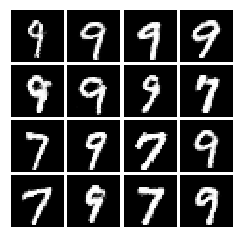

Round 232000, g_loss 3.3692145347595215, d_loss 0.15437978506088257


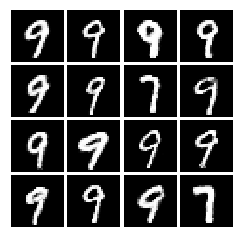

Round 233000, g_loss 3.5252418518066406, d_loss 0.17842261493206024


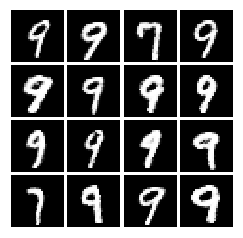

Round 234000, g_loss 3.2745630741119385, d_loss 0.2152041494846344


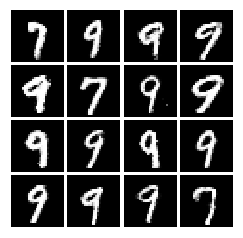

Round 235000, g_loss 3.660006046295166, d_loss 0.23163212835788727


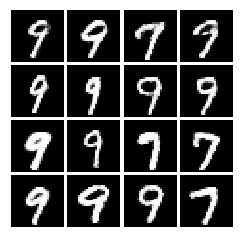

Round 236000, g_loss 3.389604091644287, d_loss 0.31581830978393555


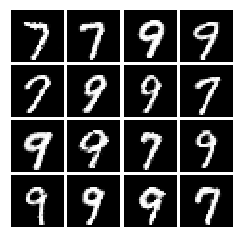

Round 237000, g_loss 3.5899152755737305, d_loss 0.32614922523498535


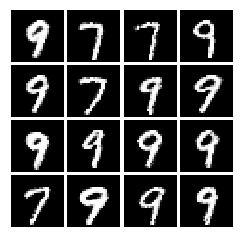

Round 238000, g_loss 3.954592227935791, d_loss 0.16199848055839539


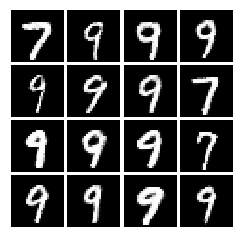

Round 239000, g_loss 3.7589495182037354, d_loss 0.17453289031982422


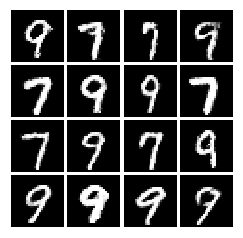

Round 240000, g_loss 3.734596014022827, d_loss 0.20987661182880402


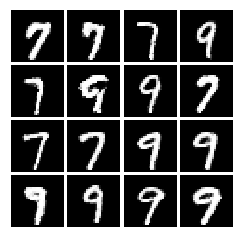

Round 241000, g_loss 3.485382080078125, d_loss 0.3322165310382843


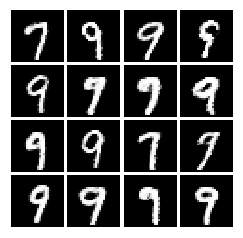

Round 242000, g_loss 3.9244673252105713, d_loss 0.27444934844970703


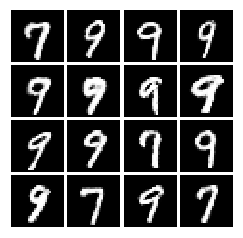

Round 243000, g_loss 3.8081417083740234, d_loss 0.25810378789901733


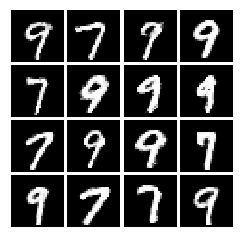

Round 244000, g_loss 3.911252021789551, d_loss 0.2661089301109314


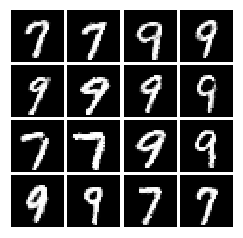

Round 245000, g_loss 3.510258436203003, d_loss 0.2565341591835022


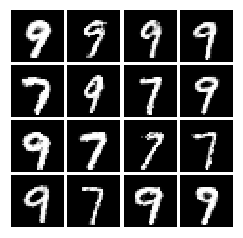

Round 246000, g_loss 4.114555358886719, d_loss 0.19250108301639557


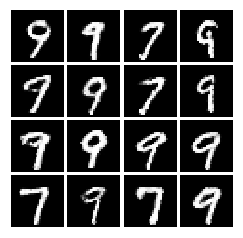

Round 247000, g_loss 4.849374771118164, d_loss 0.3414221405982971


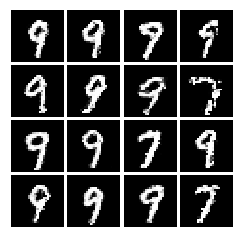

Round 248000, g_loss 3.4935786724090576, d_loss 0.19254478812217712


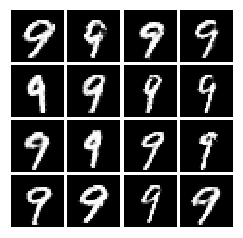

Round 249000, g_loss 3.2402939796447754, d_loss 0.23094682395458221


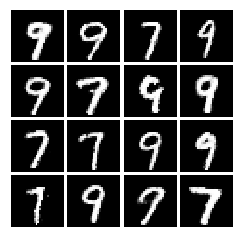

Round 250000, g_loss 3.1732988357543945, d_loss 0.3166150450706482


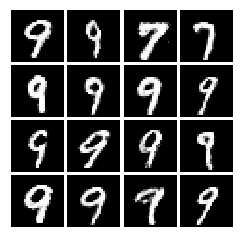

Round 251000, g_loss 3.9051387310028076, d_loss 0.1798299252986908


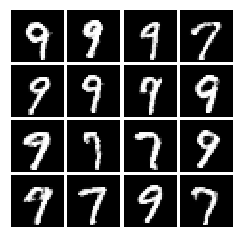

Round 252000, g_loss 3.442370891571045, d_loss 0.22545191645622253


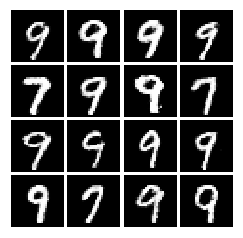

Round 253000, g_loss 4.197501182556152, d_loss 0.23309682309627533


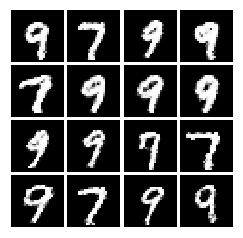

Round 254000, g_loss 3.1328346729278564, d_loss 0.13464540243148804


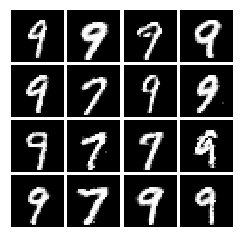

Round 255000, g_loss 4.143557071685791, d_loss 0.21747170388698578


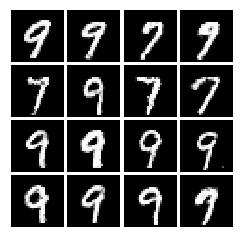

Round 256000, g_loss 3.8664538860321045, d_loss 0.13153401017189026


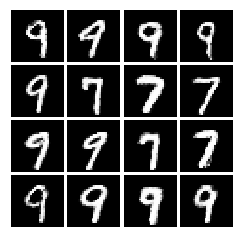

Round 257000, g_loss 3.3818516731262207, d_loss 0.16132709383964539


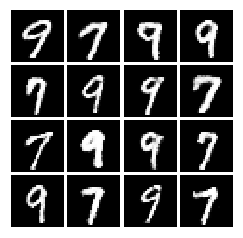

Round 258000, g_loss 3.378333568572998, d_loss 0.23415303230285645


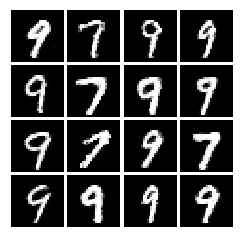

Round 259000, g_loss 4.1018781661987305, d_loss 0.10788128525018692


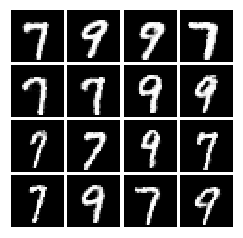

Round 260000, g_loss 3.2445316314697266, d_loss 0.23542168736457825


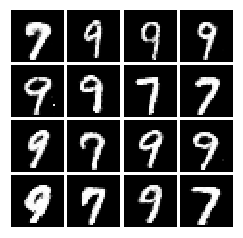

Round 261000, g_loss 3.60931134223938, d_loss 0.24929791688919067


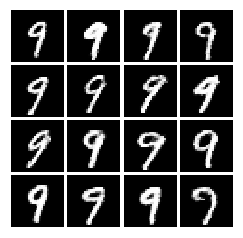

Round 262000, g_loss 3.9738285541534424, d_loss 0.2435685396194458


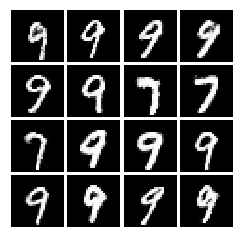

Round 263000, g_loss 3.6014833450317383, d_loss 0.20100799202919006


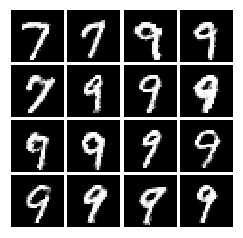

Round 264000, g_loss 3.5131759643554688, d_loss 0.3734758496284485


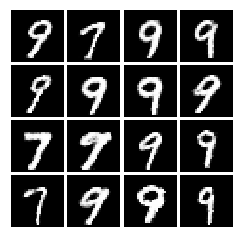

Round 265000, g_loss 3.9097766876220703, d_loss 0.28881949186325073


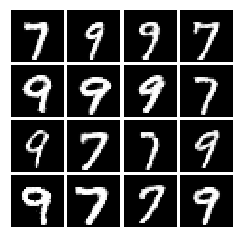

Round 266000, g_loss 3.747344732284546, d_loss 0.15576761960983276


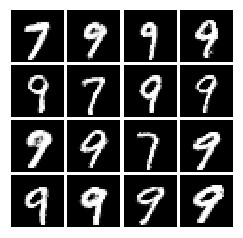

Round 267000, g_loss 3.654813766479492, d_loss 0.08716952800750732


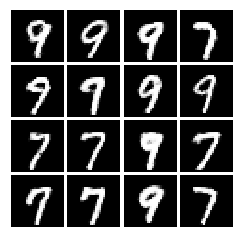

Round 268000, g_loss 3.3434274196624756, d_loss 0.25347456336021423


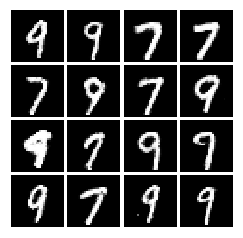

Round 269000, g_loss 3.5700297355651855, d_loss 0.21165210008621216


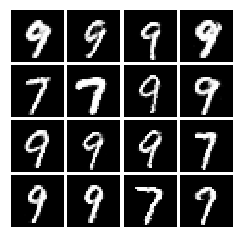

Round 270000, g_loss 4.470617771148682, d_loss 0.2283647060394287


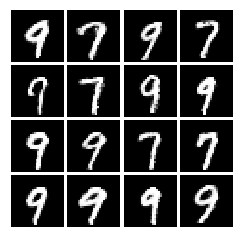

Round 271000, g_loss 4.081498146057129, d_loss 0.2943292260169983


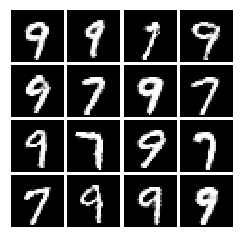

Round 272000, g_loss 3.6945981979370117, d_loss 0.22952009737491608


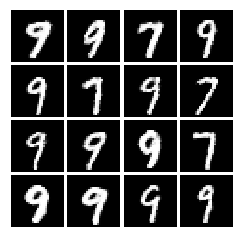

Round 273000, g_loss 3.530845880508423, d_loss 0.19927817583084106


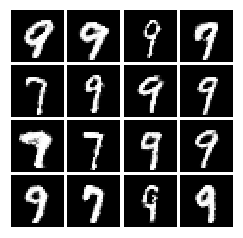

Round 274000, g_loss 3.3323779106140137, d_loss 0.21483123302459717


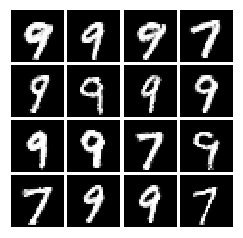

Round 275000, g_loss 3.6311259269714355, d_loss 0.20384785532951355


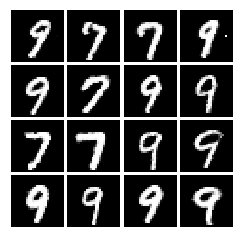

Round 276000, g_loss 3.96872615814209, d_loss 0.0921354591846466


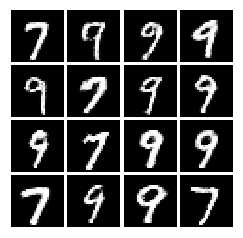

Round 277000, g_loss 3.9083499908447266, d_loss 0.1329360008239746


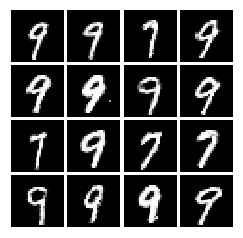

Round 278000, g_loss 3.885805130004883, d_loss 0.15358586609363556


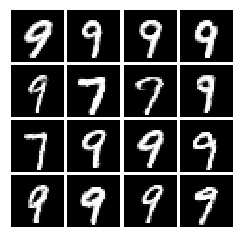

Round 279000, g_loss 3.8773117065429688, d_loss 0.17648422718048096


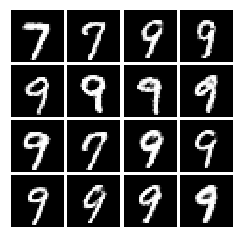

Round 280000, g_loss 3.8828465938568115, d_loss 0.17331074178218842


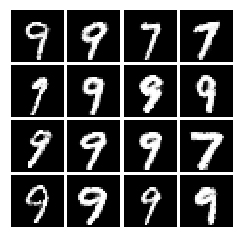

Round 281000, g_loss 3.562265634536743, d_loss 0.13470558822155


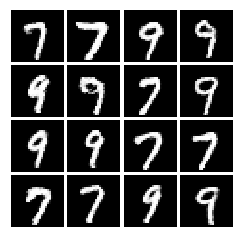

Round 282000, g_loss 3.9036827087402344, d_loss 0.1298331320285797


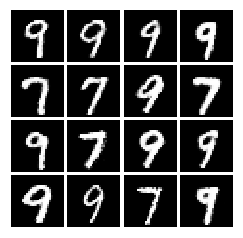

Round 283000, g_loss 3.8674967288970947, d_loss 0.19190344214439392


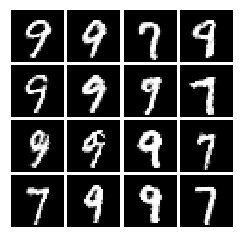

Round 284000, g_loss 3.4698727130889893, d_loss 0.30958765745162964


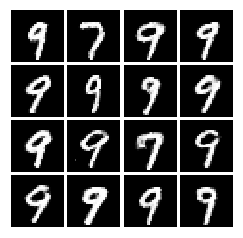

Round 285000, g_loss 3.6117324829101562, d_loss 0.24302750825881958


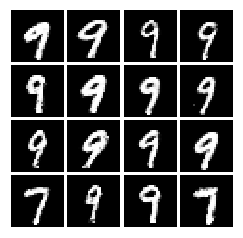

Round 286000, g_loss 3.8357410430908203, d_loss 0.15730483829975128


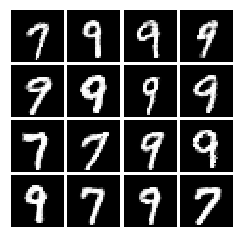

Round 287000, g_loss 3.649066925048828, d_loss 0.25012505054473877


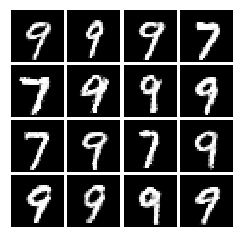

Round 288000, g_loss 3.849076986312866, d_loss 0.13596214354038239


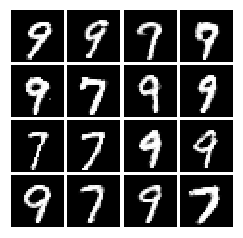

Round 289000, g_loss 3.844316244125366, d_loss 0.26710575819015503


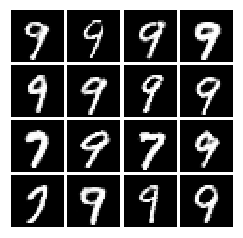

Round 290000, g_loss 3.9784398078918457, d_loss 0.2548443675041199


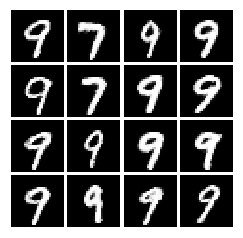

Round 291000, g_loss 4.045933723449707, d_loss 0.30559247732162476


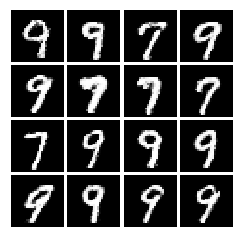

Round 292000, g_loss 3.8266677856445312, d_loss 0.3382839262485504


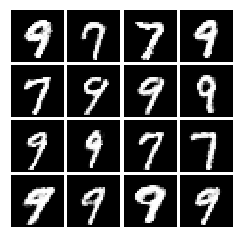

Round 293000, g_loss 3.9226436614990234, d_loss 0.21477915346622467


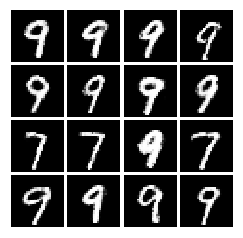

Round 294000, g_loss 4.041587829589844, d_loss 0.2674400210380554


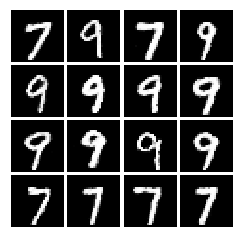

Round 295000, g_loss 4.278372764587402, d_loss 0.17459917068481445


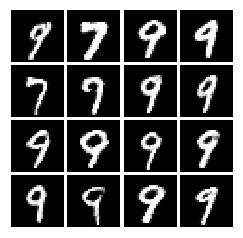

Round 296000, g_loss 4.264448642730713, d_loss 0.2455926090478897


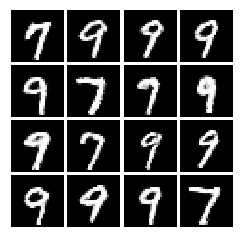

Round 297000, g_loss 3.6735949516296387, d_loss 0.11315341293811798


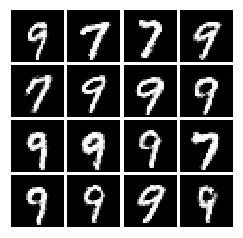

Round 298000, g_loss 3.834522008895874, d_loss 0.14872513711452484


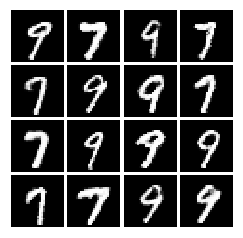

Round 299000, g_loss 3.980663299560547, d_loss 0.1971937119960785


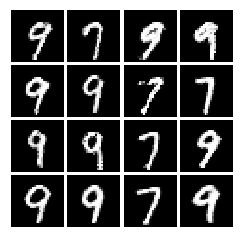

Round 300000, g_loss 4.195123672485352, d_loss 0.1831691563129425


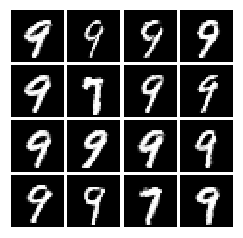

Round 301000, g_loss 4.203524589538574, d_loss 0.14726586639881134


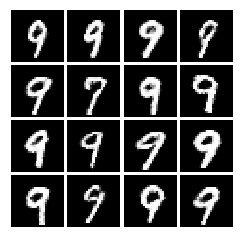

Round 302000, g_loss 3.802685022354126, d_loss 0.2501991093158722


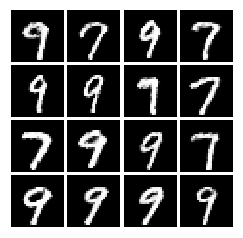

Round 303000, g_loss 3.9545609951019287, d_loss 0.15405075252056122


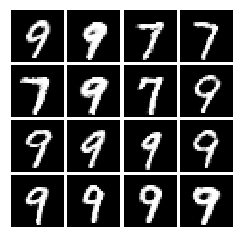

Round 304000, g_loss 4.006242275238037, d_loss 0.20584331452846527


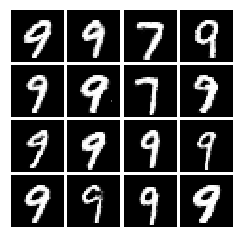

Round 305000, g_loss 4.1308770179748535, d_loss 0.20244556665420532


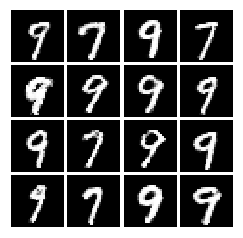

Round 306000, g_loss 4.3514204025268555, d_loss 0.32099229097366333


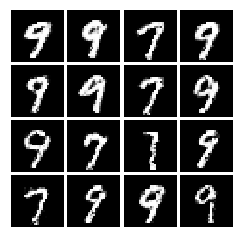

Round 307000, g_loss 3.7823760509490967, d_loss 0.24781161546707153


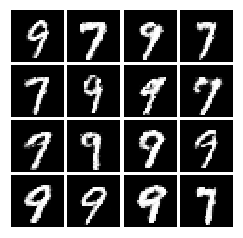

Round 308000, g_loss 3.90453839302063, d_loss 0.24312034249305725


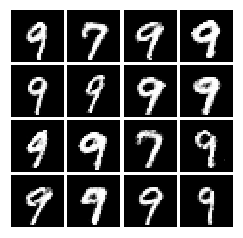

Round 309000, g_loss 3.9478373527526855, d_loss 0.16343502700328827


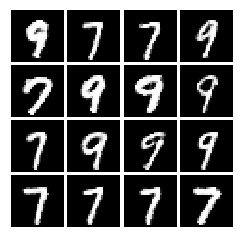

Round 310000, g_loss 4.382540702819824, d_loss 0.2564670145511627


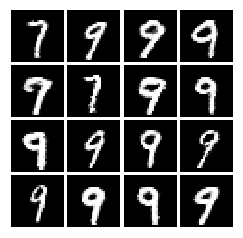

Round 311000, g_loss 4.123291492462158, d_loss 0.1558227837085724


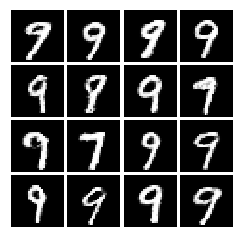

Round 312000, g_loss 3.8118183612823486, d_loss 0.16480645537376404


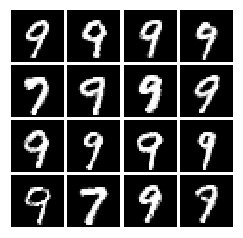

Ended


In [4]:
gan.train(mnist, max_epochs=10000)

In [ ]:
### Use the trained gan to generate a batch of images

In [ ]:
samples = gan.generate(sample_z(16, gan.architecture[0]))
plot(samples[0])